# Analyze Kaggle ELO Data

In [1]:
import pandas as panda

import numpy as np

import datetime, time

from matplotlib.pyplot import plot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns


from sklearn.linear_model import LinearRegression, RANSACRegressor, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
historical_transaction_data_path = 'all/historical_transactions.csv'

merchant_data_path = 'all/merchants.csv'

new_merchant_data_path = 'all/new_merchant_transactions.csv'

train_data_path = 'all/train.csv'

test_data_path = 'all/test.csv'


In [3]:
historical_data = panda.read_csv(historical_transaction_data_path)
# historical_store = panda.HDFStore('all/historical_store.h5')
# historical_store['df'] = historical_data


merchant_data = panda.read_csv(merchant_data_path)
# merchant_store = panda.HDFStore('all/merchant_data.h5')
# merchant_store['df'] = merchant_data

new_merchant_data = panda.read_csv(new_merchant_data_path)
# new_merchant_store = panda.HDFStore('all/new_merchant_data.h5')
# new_merchant_store['df'] = new_merchant_data

train_data = panda.read_csv(train_data_path)
# train_data_store = panda.HDFStore('all/train_data.h5')
# train_data_store['df'] = train_data

test_data = panda.read_csv(test_data_path)
# test_data_store = panda.HDFStore('all/test_data.h5')
# test_data_store['df'] = test_data



The very first things we would do are:

1. Find out the number of unique cards

2.  FInd out the number of cards whose transactions have never been denied. Find out the number of cards whose transactions have been denied

3. read the loyalty score of never been denied cards from the train set. A higher score means higher loyalty score is better than lower.


4. a few more markers of loyalty could be

        - how long the cards have been active
        - how many transactions have been made
        - how high value transaction has been made
        
        
5. we can also use pair plots and stat scores to find relation between data features in the training data
        
        
Potential problem areas:

1. may be our final training data needs to be join between the merchant and transaction data .

2. how do we encode our data ranges

3. dealing with empty data in each set- transaction, merchant , historical transaction
        
        

##lets first deal with only new data and see our scores. historical data we will ignore for now.

step 1: encoding for dates/ and date range

step 2: empty data or inf data in data sets in new transactions data


step 3: empty data or inf data in data sets in merchant data


step 4: find out for each card how many approved transactions were made. value of purchase of each. add that to training set.


step 5: run a regression model to check for scores. we are checking RMSE



** find out high value merchants. and add that indicator to training data set
** enhance the model above to inculcate historical data




In [4]:

train_data = panda.read_csv(train_data_path)

card_ids = train_data[['card_id']].values

print('All cards are unique: ',np.unique(card_ids).shape[0] == card_ids.shape[0], ' number of unique cards : ', card_ids.shape[0])


All cards are unique:  True  number of unique cards :  201917


In [5]:
## in this particular piece, we find the cards whose transactions have been denied in the past. and in the present

historical_data = panda.read_csv(historical_transaction_data_path)
new_merchant_data = panda.read_csv(new_merchant_data_path)
card_ids_denied_recently= new_merchant_data.loc[new_merchant_data['authorized_flag']=='N', ['card_id']]
card_ids_denied_past = historical_data.loc[historical_data['authorized_flag']=='N', ['card_id']]


# trial = panda.DataFrame([[11,22],[111,222],[11,222],[1,2],[2,22],[3,22],[4,22],[5,22]])
# trial.columns = ['A' , 'B']

# trial.loc[trial['A']==11, ['A','B']]


In [6]:
card_ids_denied_past = card_ids_denied_past.apply(lambda x: x.str.upper().str.strip())
card_ids_denied_past_unique = np.unique(card_ids_denied_past)
print(card_ids_denied_recently, card_ids_denied_past_unique.shape, card_ids_denied_past_unique)






Empty DataFrame
Columns: [card_id]
Index: [] (275701,) ['C_ID_00007093C1' 'C_ID_0001238066' 'C_ID_0001506EF0' ...
 'C_ID_FFFF756266' 'C_ID_FFFF828181' 'C_ID_FFFFFD5772']


In [7]:

card_ids = np.vectorize(lambda x: x.upper().strip())(card_ids)
card_ids_unique = np.unique(card_ids)

## you want to find the card_ids which are in card_ids_denied_past_unique
print(card_ids_unique.shape, card_ids_denied_past_unique.shape)

# card_ids_unique_reshaped = [i for i in np.reshape(card_ids_unique, (card_ids_unique.shape[0],))]
# card_ids_denied_past_unique_reshaped = [ i for i in np.reshape(card_ids_denied_past_unique, (card_ids_denied_past_unique.shape[0],))]



(201917,) (275701,)


In [8]:
card_ids_denied_= np.intersect1d(card_ids_unique,card_ids_denied_past_unique)
print(card_ids_denied_, card_ids_denied_.shape)
## number of cards denied 170958 out of a total of 201917

['C_ID_00007093C1' 'C_ID_0001506EF0' 'C_ID_000183FDDA' ...
 'C_ID_FFFF579D3A' 'C_ID_FFFF828181' 'C_ID_FFFFFD5772'] (170958,)


In [9]:
train_data[['card_id']] = train_data[['card_id']].apply(lambda x: x.str.upper().str.strip())

# train_data.head()
temp_data_for_denied_cards = train_data.merge(panda.DataFrame({'card_id': card_ids_denied_}), how='inner', on ='card_id')
print(temp_data_for_denied_cards['target'].value_counts())
## we can see that there is a whole range of values for target irrespective of getting card denied

## lets check for card not denied
temp_data_for_not_denied_cards = train_data[~train_data.card_id.isin(card_ids_denied_)]

print(temp_data_for_not_denied_cards.target.value_counts()) ## again a mix of numbers for not denied operations on cards as well


-33.219281    2003
 0.000000      851
 1.000000       90
-1.000000       55
-0.584963       23
 0.584963       20
-1.321928       15
-0.415038       10
 1.584963       10
 0.284918       10
 2.000000        9
 1.321928        8
 0.321928        7
-1.584963        7
-0.321928        7
-0.263034        7
 0.736966        7
-2.000000        7
 0.514573        6
-0.514573        6
-3.321928        6
-0.736966        5
-0.018908        5
 0.342052        5
-2.321928        5
 2.321928        5
-0.222392        5
 0.807355        5
 0.415038        5
 0.160913        4
              ... 
-0.099562        1
-1.971726        1
-4.594310        1
 0.215819        1
-1.421411        1
 1.172972        1
 0.060912        1
 0.454622        1
-0.617051        1
-0.501328        1
-0.101853        1
-3.388015        1
-0.306922        1
-3.663180        1
 2.127001        1
 0.733883        1
 2.025995        1
 1.286548        1
 0.757786        1
 0.313426        1
 1.321272        1
-0.644840   

In [10]:


current_date = '2018-12'
given_date = '2015-12'

# from datetime import datetime
from dateutil import relativedelta


def get_months_passed( given):
    
    current = datetime.datetime.now()
    given = datetime.datetime.strptime(given + '-01', '%Y-%m-%d')
    
    r = relativedelta.relativedelta(current, given)
    return r.months + r.years*12


    
    
get_months_passed( given_date)    
    
    
    

36

how do we handle dates in train data

1. we will count the difference in months between current date and given date. add day end as 01. 

2. we will now get a count of how old the data is - which is now a numerical figure




In [11]:

train_data['months_passed'] = train_data['first_active_month'].apply(lambda x: get_months_passed(x))
train_data




,first_active_month,card_id,feature_1,feature_2,feature_3,target,months_passed
0,2017-06,C_ID_92A2005557,5,2,1,-0.820283,18
1,2017-01,C_ID_3D0044924F,4,1,0,0.392913,23
2,2016-08,C_ID_D639EDF6CD,2,2,0,0.688056,28
3,2017-09,C_ID_186D6A6901,4,3,0,0.142495,15
4,2017-11,C_ID_CDBD2C0DB2,1,3,0,-0.159749,13
5,2016-09,C_ID_0894217F2F,4,2,0,0.871585,27
6,2016-12,C_ID_7E63323C00,3,2,1,0.230129,24
7,2017-09,C_ID_DFA21FC124,3,2,1,2.135850,15
8,2017-08,C_ID_FE0FDAC8EA,2,1,0,-0.065406,16
9,2016-08,C_ID_BF62C0B49D,2,2,0,0.300062,28


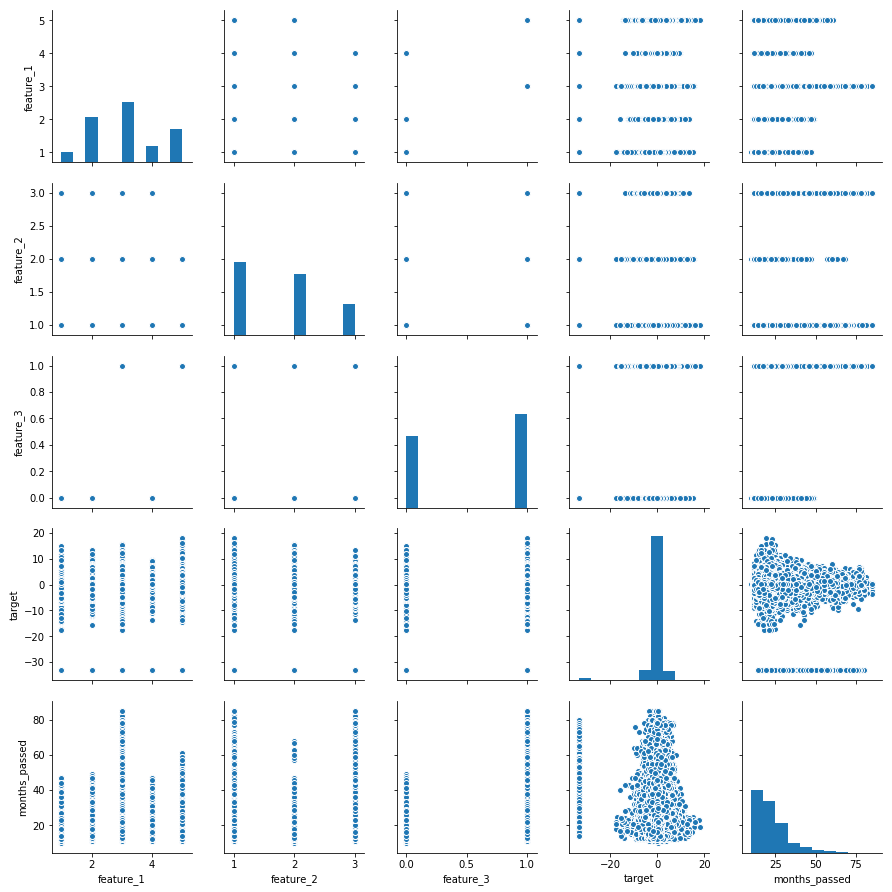

In [12]:
sns.pairplot(train_data[[i for i in train_data.columns.tolist() if i!='card_id' and i!='first_active_month' ]])

Lets concentrate on the graphs at 4th node. it is very clear that for certain values of months passed, feature 1,2,3 there are outliers affecting the target. else target is pretty much spread pretty evenly compared to the attributes


from the graph itself we can see that, target values under the range of -30 are the outliers. rest of the target values are prettu evenly placed around a particular range of -20 to 20

### we will proceed to run a regression model on the training data itself. using only the training data and the columns feature_1,feature_2. feature_3, and months passed as independent variables and target as a dependent variable

In [13]:
round1_training_data_ = train_data[[i for i in train_data.columns.tolist() if i!='card_id' and i!='first_active_month' ]]

round1_x = round1_training_data_[[i for i in round1_training_data_.columns.tolist() if i!='target']]
round1_y = round1_training_data_.target

round1_x_train, round1_x_test, round1_y_train, round1_y_test = train_test_split(round1_x, round1_y, test_size = 0.3, random_state = 12)

print(round1_x_train.shape, round1_x_test.shape, round1_y_train.shape,round1_y_test.shape)

(141341, 4) (60576, 4) (141341,) (60576,)


In [14]:

from math import sqrt

def root_mean_square_error(y, y_predicted):
    
    return mean_squared_error(y,y_predicted)
    
scorer = make_scorer(root_mean_square_error, greater_is_better=False)

In [15]:

classifiers = [
    LinearRegression(),
    RANSACRegressor(),
    DecisionTreeRegressor(random_state = 1, criterion = 'mse'),
    RandomForestRegressor(random_state = 1, criterion = 'mse'),
    SGDRegressor(),
#     SVR( kernel = 'rbf'),    
]


classifier_names = [
            'linear_regression',
            'ransac_regression',
            'decisiontree_regression',
            'randomforest_regression',
            'gradient_descent_regression',
#             'svr',               
    
]

classifier_param_grid = [
            
            {},
            {'ransac_regression__min_samples':[50, 75, 125, 200], 'ransac_regression__max_trials':[50, 125, 200], 'ransac_regression__residual_threshold':[5, 10, 14]},
            {'decisiontree_regression__max_depth':[6,7,8,9,10,11]},
            {'randomforest_regression__n_estimators':[1,2,3,5,6]} ,
            {'gradient_descent_regression__max_iter' : [100, 200, 300]},
#             {'svr__C':[1, 10, 20]},
    
]


    

class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))



def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'neg_mean_squared_error'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')

    with training_timer:

        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("Mean squared error score %s" %mean_squared_error(y_test,y_prediction))
    
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
    response['training_time'] = training_timer.took    
    response['mean_squared_error'] = mean_squared_error(y_test,y_prediction)
    response['root_mean_squared_error'] = search.best_score_
    response['r2_score'] = r2_score(y_test,y_prediction)
    response['best_estimator'] = search.best_estimator_
    
    return response
    


def analyzeRegressionModel(X,y):

    
    _x_train, _x_test, _y_train, _y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

    model_metrics = {}

    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid, score = scorer)

            _y_prediction = result['_y_prediction']

            model_metrics[model_name] = {}
            model_metrics[model_name]['training_time'] = result['training_time']
            model_metrics[model_name]['testing_time'] = result['testing_time']
            model_metrics[model_name]['r2_score'] = result['r2_score']
            model_metrics[model_name]['mean_squared_error'] = result['mean_squared_error']
            model_metrics[model_name]['root_mean_squared_error'] = result['root_mean_squared_error']
            model_metrics[model_name]['best_estimator'] = result['best_estimator']
            
    return model_metrics
    print('Model metrics are \n :', model_metrics)


In [16]:
model_metrics = analyzeRegressionModel(round1_x, round1_y)

Grid Search Best parameters  {}
Grid Search Best score  -14.7257552674788
Code block 'training' took(HH:MM:SS): 0:00:00.615257
Code block 'testing' took(HH:MM:SS): 0:00:00.003131
Mean squared error score 14.931230033246353
Grid Search Best parameters  {'ransac_regression__max_trials': 125, 'ransac_regression__min_samples': 75, 'ransac_regression__residual_threshold': 5}
Grid Search Best score  -14.88956977223585
Code block 'training' took(HH:MM:SS): 0:01:14.358002
Code block 'testing' took(HH:MM:SS): 0:00:00.003329
Mean squared error score 15.105271775440125
Grid Search Best parameters  {'decisiontree_regression__max_depth': 6}
Grid Search Best score  -14.709311427855736
Code block 'training' took(HH:MM:SS): 0:00:06.924752
Code block 'testing' took(HH:MM:SS): 0:00:00.008258
Mean squared error score 14.901645773293138
Grid Search Best parameters  {'randomforest_regression__n_estimators': 6}
Grid Search Best score  -14.771157144230115
Code block 'training' took(HH:MM:SS): 0:00:12.870974


In [17]:
best_estimator = model_metrics['ransac_regression']['best_estimator']

In [18]:
best_estimator


## our round_1 estimator is ready.we are simply considering the training data verbatim.

## before we predict on our test data, we would have to read it and then convert the active_first value as well.
## independent variables will be feature_1,_2,_3, months_passed

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ransac_regression', RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=125,
        min_samples=75, random_state=None, residual_metric=None,
        residual_threshold=5, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf))])

In [21]:
test_data['months_passed'] = train_data['first_active_month'].apply(lambda x: get_months_passed(x))
test_data

test_x = test_data[[i for i in test_data.columns.tolist() if i not in ['card_id','first_active_month']]]
test_x.head()

,feature_1,feature_2,feature_3,months_passed
0,3,3,1,18
1,2,3,0,23
2,5,1,1,28
3,2,1,0,15
4,5,1,1,13


In [22]:
test_target = best_estimator.predict(test_x)

test_target

array([-0.01806627, -0.02499227, -0.0529428 , ..., -0.05437833,
       -0.00968468, -0.05509609])

In [27]:
## write it to a panda table

sample_submission_round_1 = test_data[['card_id']]
sample_submission_round_1['target'] = test_target


print(len(sample_submission_round_1), sample_submission_round_1.head())

sample_submission_round_1.to_csv('round1_submission.csv')

C:\Users\somak\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


123623            card_id    target
0  C_ID_0ab67a22ab -0.018066
1  C_ID_130fd0cbdd -0.024992
2  C_ID_b709037bc5 -0.052943
3  C_ID_d27d835a9f -0.009685
4  C_ID_2b5e3df5c2 -0.055096


##### lets try and see if we boost using xgboost.if it helps

In [1]:
# from xgboost import XGBRegressor



# classifiers = [
#     XGBRegressor(),
 
# ]


# classifier_names = [
#             'boost_regressor',
    
# ]

# classifier_param_grid = [
            
#             {'boost_regressor__max_depth':[3,5,6],'boost_regressor__learning_rate':[0.1,0.05]},
    
# ]

# model_metrics = analyzeRegressionModel(round1_x, round1_y)

ModuleNotFoundError: No module named 'xgboost'